CE 5364 – Groundwater Transport Phenomena FALL 2025

Exercise Set 3

Exercises

1. Figure 1 below depicts the general area where the Spill-O-Rama industrial manufacturing
plant operates, among other things Spill-O-Rama manufactures titanium knee replace-
ments, using proprietary techniques. The golf course is about 5000 meters west of the
plant boundary. The golf course opened about 1980, around the same time as the plant
began operations.

![](site_map_homework1.png)

Figure 2 below is a detail map of the plant itself showing the locations of monitoring wells
(MW) and a pumping well (PW).

![](site_map_homework2.png)

**Determine:**

**(a)** Estimate the regional groundwater flow direction from the monitoring wells.

A script to determine groundwater flow direction from the MW information is listed below.  It may look complicated, but it simply takes as input the xyz coordinates of the monitoring wells (z == head), solves the equation of a plane defined by the three points.  Then plots the points on a map.   It is reasonably generic, but I have modified some bits specific to the supplied test case.

a=-0.002643, b=-0.002664, c=123.719262
Hydraulic gradient x component == 0.002643
Hydraulic gradient y component == 0.002664


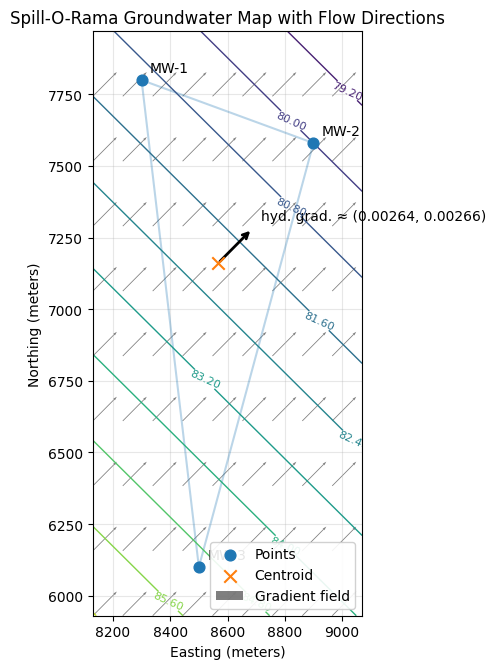

In [37]:
#!/usr/bin/env python3
"""
points_to_plane_plot.py

Given three named 3D points (name, x, y, z), solve for the plane
z(x,y) = a x + b y + c where (a, b) is the hydraulic gradient,
then produce a plot of the three (x,y) points with:
  - unit aspect ratio,
  - ~10% padded limits,
  - centroid marker,
  - a single arrow from centroid in the (a, b) direction,
  - optional contours of z(x,y),
  - optional quiver (uniform gradient field).

Usage examples
--------------
# Three points via flags (repeat --point three times)
python points_to_plane_plot.py \
  --point P1 0 0 100 \
  --point P2 10 0 98 \
  --point P3 0 10 97.5 \
  --contours 10 --quiver 10 --save plane_plot.png

# Same but just show interactively
python points_to_plane_plot.py --point A 0 0 0 --point B 1 0 -1 --point C 0 1 -1

# From CSV (name,x,y,z with header or headerless):
#   P1,0,0,100
#   P2,10,0,98
#   P3,0,10,97.5
python points_to_plane_plot.py --csv points.csv --contours 8 --quiver 12

Notes
-----
- If points imply a vertical/near-vertical plane (not representable as z=ax+by+c),
  the solve will fail with a clear message.
"""

from __future__ import annotations
import argparse
from typing import List, Tuple, Optional
import csv
import numpy as np
import matplotlib.pyplot as plt

Point = Tuple[str, float, float, float]

# ---------- Math core ----------
def solve_plane_axy_plus_by_plus_c(points: List[Point], rtol: float = 1e-12) -> Tuple[float, float, float]:
    """
    Solve z(x,y) = a x + b y + c from exactly three points (name, x, y, z).
    Returns (a, b, c). Here (a, b) is the hydraulic gradient.
    """
    if len(points) != 3:
        raise ValueError("Provide exactly three points.")
    xs = np.array([p[1] for p in points], dtype=float)
    ys = np.array([p[2] for p in points], dtype=float)
    zs = np.array([p[3] for p in points], dtype=float)

    # Build system: [x y 1] [a b c]^T = z
    M = np.column_stack([xs, ys, np.ones(3, dtype=float)])
    rank = np.linalg.matrix_rank(M, tol=rtol)
    if rank < 3:
        raise ValueError(
            "Cannot represent the plane as z = a x + b y + c.\n"
            "The points likely imply a vertical/near-vertical plane or duplicate (x,y)."
        )
    a, b, c = np.linalg.solve(M, zs)
    return float(a), float(b), float(c)

# ---------- Plotting ----------
def plot_xy_with_overlays(points: List[Point],
                          a: float, b: float, c: float,
                          arrow_frac: float = 0.10,
                          pad_frac: float = 0.10,
                          contour_levels: Optional[int | List[float]] = None,
                          quiver_grid: Optional[int] = None,
                          title: str = "Points with Plane Contours and Gradient Overlays"):
    """
    Make the requested plot with unit aspect, padding, centroid/arrow, optional contours & quiver.

    Parameters
    ----------
    arrow_frac : fraction of max(xspan, yspan) used for the centroid arrow length (default 0.10)
    pad_frac   : fractional padding added to min/max limits (default 0.10)
    contour_levels : None (no contours), int (#levels), or explicit list of levels
    quiver_grid : None (no quiver) or number of vectors per axis
    """
    names = [p[0] for p in points]
    xs = np.array([p[1] for p in points], dtype=float)
    ys = np.array([p[2] for p in points], dtype=float)
    zs = np.array([p[3] for p in points], dtype=float)

    # Centroid and spans
    X0, Y0 = xs.mean(), ys.mean()
    xspan = xs.max() - xs.min()
    yspan = ys.max() - ys.min()
    span  = max(xspan, yspan, 1e-12)
    pad   = pad_frac * span
    # Generic sizing
    xmin, xmax = xs.min() - pad, xs.max() + pad
    ymin, ymax = ys.min() - pad, ys.max() + pad
    # Override sizing
#    xmin, xmax = 0, 10000
#    ymin, ymax = 0, 10000    

    # Arrow length scale in (a,b) direction (-a,-b are gradient)
    norm_ab = float(np.hypot(a, b))
    D = (arrow_frac * span) / norm_ab if norm_ab > 1e-15 else 0.0
    X1, Y1 = X0 - a * D, Y0 - b * D

    fig, ax = plt.subplots(figsize=(6.8, 6.8))

    # Points & triangle
    ax.scatter(xs, ys, s=60, zorder=3, label="Points")
    for name, x, y in zip(names, xs, ys):
        ax.annotate(name, (x, y), textcoords="offset points", xytext=(6, 6))
    ax.plot([xs[0], xs[1], xs[2], xs[0]], [ys[0], ys[1], ys[2], ys[0]], alpha=0.3)

    # Centroid and arrow
    ax.scatter([X0], [Y0], marker='x', s=80, zorder=4, label="Centroid")
    ax.annotate("", xy=(X1, Y1), xytext=(X0, Y0),
                arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.annotate(f"hyd. grad. ≈ ({-a:.3g}, {-b:.3g})", (X1, Y1),
                textcoords="offset points", xytext=(6, 6))

    # Contours of z = a x + b y + c
    if contour_levels is not None:
        gx = np.linspace(xmin, xmax, 201)
        gy = np.linspace(ymin, ymax, 201)
        XX, YY = np.meshgrid(gx, gy, indexing="xy")
        ZZ = a * XX + b * YY + c
        cs = ax.contour(XX, YY, ZZ, levels=contour_levels, linewidths=1.0)
        ax.clabel(cs, inline=True, fmt="%.2f", fontsize=8)

    # Quiver: constant field (a,b); normalize for clean visual
    if quiver_grid is not None and norm_ab > 1e-15:
        qx = np.linspace(xmin, xmax, quiver_grid)
        qy = np.linspace(ymin, ymax, quiver_grid)
        QX, QY = np.meshgrid(qx, qy, indexing="xy")
        u = -a / norm_ab
        v = -b / norm_ab
        scale = 0.07 * span  # vector length ~7% of span
        ax.quiver(QX, QY, u, v, angles='xy', scale_units='xy', scale=1/scale,
                  width=0.003, alpha=0.5, label="Gradient field")

    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
# manual override limits
#    ax.set_xlim(0, 10000)  # Manual Override 
#    ax.set_ylim(0, 10000)  # Manual Override 
    ax.grid(True, alpha=0.3)
#    ax.legend(loc="best", framealpha=0.9)
    ax.legend(loc="lower right", framealpha=0.9)
    plt.tight_layout()
    return fig, ax

# ---------- I/O helpers ----------
def read_points_from_csv(path: str) -> List[Point]:
    points: List[Point] = []
    with open(path, newline="") as f:
        rdr = csv.reader(f)
        for row in rdr:
            if not row or row[0].strip().startswith("#"):
                continue
            # Try to detect header: name,x,y,z
            if len(row) >= 4 and row[1].strip().lower() == "x" and row[2].strip().lower() == "y":
                continue
            name = row[0].strip()
            x = float(row[1]); y = float(row[2]); z = float(row[3])
            points.append((name, x, y, z))
    if len(points) != 3:
        raise ValueError(f"CSV must contain exactly 3 points; got {len(points)}.")
    return points

def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Solve z=a x + b y + c from 3 points and plot overlays.")
    src = p.add_mutually_exclusive_group(required=True)
    src.add_argument("--csv", type=str, help="CSV file with rows: name,x,y,z (header ok).")
    src.add_argument("--point", nargs=4, action="append", metavar=("NAME","X","Y","Z"),
                     help="Specify a point (repeat exactly three times).")
    p.add_argument("--contours", type=str, default=None,
                   help="Contour levels: integer (e.g., 10) or comma list (e.g., 95,96,97).")
    p.add_argument("--quiver", type=int, default=None,
                   help="Quiver grid size (e.g., 10). Omit for no quiver.")
    p.add_argument("--arrow-frac", type=float, default=0.10,
                   help="Centroid arrow length as fraction of plot span (default 0.10).")
    p.add_argument("--pad-frac", type=float, default=0.10,
                   help="Axis padding as fraction of span (default 0.10).")
    p.add_argument("--save", type=str, default=None, help="Path to save the figure (e.g., out.png).")
    p.add_argument("--title", type=str, default="Points with Plane Contours and Gradient Overlays")
    return p.parse_args()

def coerce_points_from_args(ns: argparse.Namespace) -> List[Point]:
    if ns.csv:
        return read_points_from_csv(ns.csv)
    assert ns.point is not None
    if len(ns.point) != 3:
        raise ValueError(f"Provide exactly three --point entries; got {len(ns.point)}.")
    pts: List[Point] = []
    for name, sx, sy, sz in ns.point:
        pts.append((str(name), float(sx), float(sy), float(sz)))
    return pts

def parse_contour_levels(s: Optional[str]) -> Optional[int | List[float]]:
    if s is None:
        return None
    s = s.strip()
    # integer?
    try:
        return int(s)
    except ValueError:
        pass
    # list
    levels: List[float] = [float(tok) for tok in s.split(",") if tok.strip() != ""]
    if not levels:
        return None
    return levels

# ---------- Main ----------
def main():
    ns = parse_args()
    points = coerce_points_from_args(ns)
    a, b, c = solve_plane_axy_plus_by_plus_c(points)

    print(f"a = {a:.6f}, b = {b:.6f}, c = {c:.6f}")
    print(f"Hydraulic gradient x component == {-a:.6f}")
    print(f"Hydraulic gradient y component == {-b:.6f}")
    print(f"Plane: z(x,y) = {a:.6f} x + {b:.6f} y + {c:.6f}")

    levels = parse_contour_levels(ns.contours)
    fig, ax = plot_xy_with_overlays(points, a, b, c,
                                    arrow_frac=ns.arrow_frac,
                                    pad_frac=ns.pad_frac,
                                    contour_levels=levels,
                                    quiver_grid=ns.quiver,
                                    title=ns.title)
    if ns.save:
        fig.savefig(ns.save, dpi=200, bbox_inches="tight")
        print(f"Saved figure to: {ns.save}")
    else:
        plt.show()

if __name__ == "__main__":
### SUPPLY MW DATA AS A LIST OF TUPLES ###
    pts = [
        ("MW-1", 8300.0, 7800.0, 81.0),
        ("MW-2", 8900.0, 7580.0, 80.0),
        ("MW-3", 8500.0, 6100.0, 85.0),
    ]
### EQUATION OF THE PLANE ###
    a, b, c = solve_plane_axy_plus_by_plus_c(pts)
    print(f"a={a:.6f}, b={b:.6f}, c={c:.6f}")
    print(f"Hydraulic gradient x component == {-a:.6f}")
    print(f"Hydraulic gradient y component == {-b:.6f}")

### GENERATE PRETTY PLOT ###
    # manual adjust in plotting function to extend plot area
    myTitle = "Spill-O-Rama Groundwater Map with Flow Directions"
    plot_xy_with_overlays(pts, a, b, c, arrow_frac=0.10, pad_frac=0.10,contour_levels = 10,quiver_grid = 10, title = myTitle)

The plot above indicates the flow direction, in terms of angle relative to the Easting axis:

In [131]:
import math
radians = math.atan(b/a)
degrees = radians * 180.0 / math.pi
print(f"Flow direction : {degrees:10.3} degrees above horizontal")

Flow direction :       45.2 degrees above horizontal


**(b)** Is the groundwater flow direction favorable for constituients to move from the golf
course to the plant site?

Yes. Groundwater flows about N44.8°E (i.e., 44.8° north of due east). Because the golf course lies southwest of the plant site, this flow direction points from the golf course toward the Spill-O-Rama location. Consequently, constituents originating at the golf course are expected to migrate toward—and may ultimately be captured by—the Spill-O-Rama well, acknowledging travel-time and aquifer-property uncertainties.

**(c)** Estimate the hydraulic conductivity based on the pumping test results.

Here we will employ some model of the aquifer system.  While it is unconfined, the drawdowns are comparatively small, so we will use the Theis solution and build a modeling tool to find $T$ and $S$, then divide the result for $T$ by the "average" saturated thickness to approximate $K$

The distances from the PW1 to MW1, MW2, MW3 are estimated from the drawings.  Two scripts follow:

1. A pump test simulator that simply plots drawdown as a function of input guesses, and include markers for the observations.
2. A refinement step to find solutions that minimize model and observation error.

First the simulator:

Params:  S=0.001  K=0.001 m/min  T=0.085 m^2/min  Q=0.378858 m^3/min
Radii:   r1=500 m, r2=750 m, r3=1250 m
SSR:     MW1=5.58681, MW2=2.64563, MW3=0.76219,  TOTAL=8.99464
RMSE:    MW1=0.712666, MW2=0.49042, MW3=0.26323


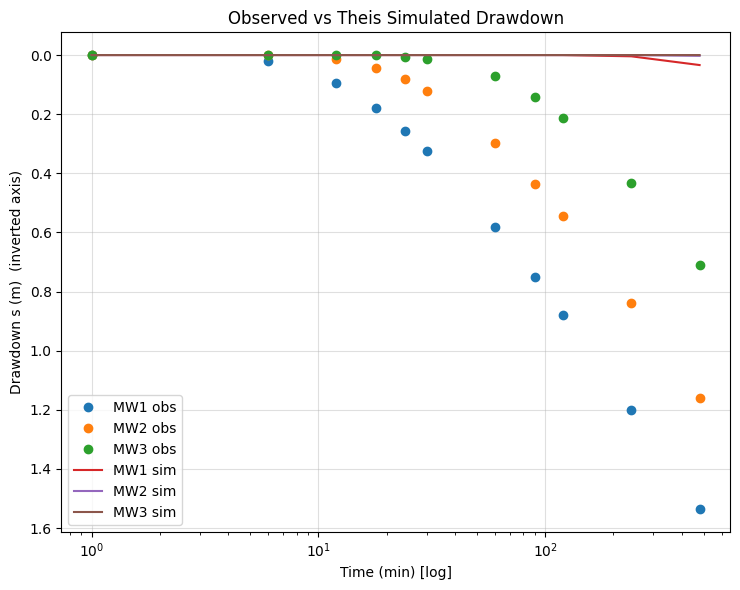

In [132]:
# Pump Test Analysis
import math
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable
from scipy.special import expn  # E1(u) = expn(1, u)

### Prototype well functions (from CE 4363/5363 - also in the review materials)
def W(u: np.ndarray) -> np.ndarray:
    """Theis well function using exponential integral E1(u). u must be > 0."""
    return expn(1, u)

def theis_drawdown(r: float, t: np.ndarray, S: float, T: float, Q: float) -> np.ndarray:
    """
    s(r,t) = (Q / (4*pi*T)) * W( u ), with u = r^2 * S / (4 * T * t)
    Units must be consistent:
      r [m], t [min], S [-], T [m^2/min], Q [m^3/min]  =>  s [m]
    """
    t = np.asarray(t, dtype=float)
    # ensure no zero time
    if np.any(t <= 0):
        raise ValueError("All times must be > 0 for Theis (appears you have t<=0).")
    u = (r**2 * S) / (4.0 * T * t)
    return (Q / (4.0 * math.pi * T)) * W(u)

# --- Observed data (from the table) ---
time_min = np.array([  1,   6,  12,  18,  24,  30,  60,  90, 120, 240, 480], dtype=float)
MW1_obs  = np.array([0.0,0.02,0.096,0.18,0.257,0.326,0.582,0.752,0.88,1.202,1.537], dtype=float)
MW2_obs  = np.array([0.0,0.001,0.015,0.045,0.082,0.121,0.298,0.436,0.546,0.84,1.16], dtype=float)
MW3_obs  = np.array([0.0,0.0,0.0,0.001,0.005,0.012,0.071,0.143,0.212,0.433,0.71], dtype=float)

# --- User-supplied guesses & constants ---
dgpm = 100                       # pumping rate [gpm]
dcfm = dgpm / 7.48               # ft^3/min
dcmm = dcfm / (3.28**3)          # m^3/min  (since 1 m ≈ 3.28 ft)
discharge = dcmm                 # Q [m^3/min]

storage = 0.001                # S [-]      GUESS THIS VALUE
hydk    = 0.001                # K [m/min]  GUESS THIS VALUE
thick_b = 85.0                  # aquifer thickness b [m] GUESS THIS VALUE
transmissivity = hydk * thick_b  # T [m^2/min]

# --- Distances well -> monitoring points (REQUIRED; set these) ---
r1 = 500   # distance to MW1 [m]
r2 = 750   # distance to MW2 [m]
r3 = 1250  # distance to MW3 [m]

if any(r is None for r in (r1, r2, r3)):
    raise ValueError("Please set r1, r2, r3 (meters) before running.")

# --- Simulate ---
MW1_sim = theis_drawdown(r1, time_min, storage, transmissivity, discharge)
MW2_sim = theis_drawdown(r2, time_min, storage, transmissivity, discharge)
MW3_sim = theis_drawdown(r3, time_min, storage, transmissivity, discharge)

# --- Residual diagnostics ---
def ssr(y_obs: np.ndarray, y_sim: np.ndarray) -> float:
    r = np.asarray(y_obs) - np.asarray(y_sim)
    return float(np.sum(r*r))

def rmse(y_obs: np.ndarray, y_sim: np.ndarray) -> float:
    r = np.asarray(y_obs) - np.asarray(y_sim)
    return float(np.sqrt(np.mean(r*r)))

ssr1, ssr2, ssr3 = ssr(MW1_obs, MW1_sim), ssr(MW2_obs, MW2_sim), ssr(MW3_obs, MW3_sim)
rmse1, rmse2, rmse3 = rmse(MW1_obs, MW1_sim), rmse(MW2_obs, MW2_sim), rmse(MW3_obs, MW3_sim)
ssr_total = ssr1 + ssr2 + ssr3

print(f"Params:  S={storage:.6g}  K={hydk:.6g} m/min  T={transmissivity:.6g} m^2/min  Q={discharge:.6g} m^3/min")
print(f"Radii:   r1={r1} m, r2={r2} m, r3={r3} m")
print(f"SSR:     MW1={ssr1:.6g}, MW2={ssr2:.6g}, MW3={ssr3:.6g},  TOTAL={ssr_total:.6g}")
print(f"RMSE:    MW1={rmse1:.6g}, MW2={rmse2:.6g}, MW3={rmse3:.6g}")

# --- Plot: observed vs simulated (y inverted). Choose linear or log x-axis. ---
use_log_time = True  # set True for log-time plot

fig, ax = plt.subplots(figsize=(7.5, 6))
# Observations
ax.plot(time_min, MW1_obs, 'o', label='MW1 obs')
ax.plot(time_min, MW2_obs, 'o', label='MW2 obs')
ax.plot(time_min, MW3_obs, 'o', label='MW3 obs')
# Simulations
ax.plot(time_min, MW1_sim, '-', label='MW1 sim')
ax.plot(time_min, MW2_sim, '-', label='MW2 sim')
ax.plot(time_min, MW3_sim, '-', label='MW3 sim')

ax.set_xlabel("Time (min)" + (" [log]" if use_log_time else ""))
ax.set_ylabel("Drawdown s (m)  (inverted axis)")
ax.set_title("Observed vs Theis Simulated Drawdown")
ax.grid(True, alpha=0.4)
ax.invert_yaxis()  # low values at top
if use_log_time:
    ax.set_xscale('log')

ax.legend()
plt.tight_layout()
plt.show()


Next the optimizer, some notes:
- This is most inelegant, but it usually works.
- In a spreadsheet, we would use GRG2 tools. (In MS Excel its called the SOLVER Add-In)



===== Nonlinear least-squares fit (Theis) =====
S_hat = 1.213498e-05  ± 6.47e-08  (1σ)
K_hat = 7.138009e-04 m/min  ± 3.70e-06
T_hat = 6.067308e-02 m^2/min   (b = 85 m)
RSS (sum of squared residuals) = 0.00117601,  dof = 31
SSR by well:  MW1=0.000507541,  MW2=9.90114e-05,  MW3=0.000569461
RMSE by well: MW1=0.00679265, MW2=0.00300017, MW3=0.00719508


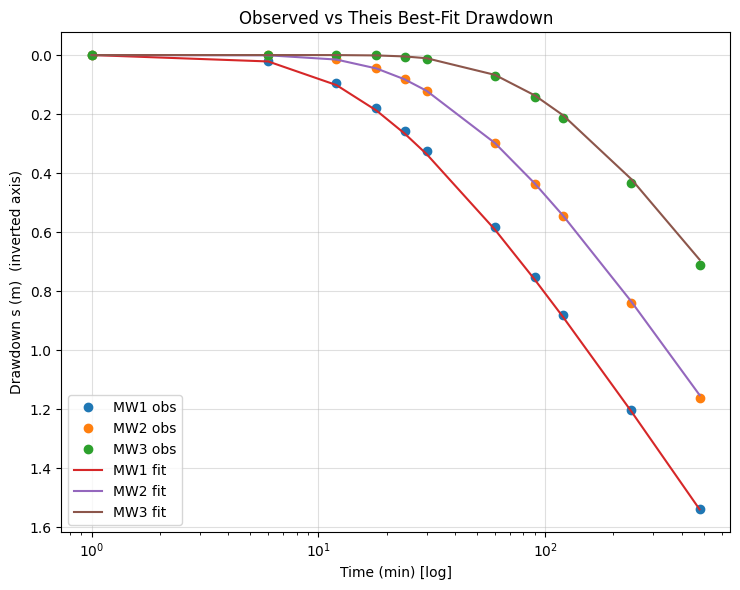

In [133]:
from scipy.optimize import least_squares
import numpy as np
import math

# --- keep your existing helpers and data in scope:
# theis_drawdown(), time_min, MW1_obs, MW2_obs, MW3_obs,
# discharge, thick_b, r1, r2, r3

# Optional well weights (e.g., emphasize nearer well).
w1, w2, w3 = 1.0, 1.0, 1.0  # tweak if desired

def residuals_log_params(theta_log10):
    """
    theta_log10 = [log10(S), log10(K_m_per_min)]
    Returns concatenated residuals for all wells (obs - sim) with optional weights.
    """
    log10S, log10K = float(theta_log10[0]), float(theta_log10[1])
    S = 10.0**log10S
    K = 10.0**log10K
    T = K * thick_b

    # simulate
    s1 = theis_drawdown(r1, time_min, S, T, discharge)
    s2 = theis_drawdown(r2, time_min, S, T, discharge)
    s3 = theis_drawdown(r3, time_min, S, T, discharge)

    # residuals = observed - simulated (same sign as your SSR function)
    res1 = w1 * (MW1_obs - s1)
    res2 = w2 * (MW2_obs - s2)
    res3 = w3 * (MW3_obs - s3)

    return np.concatenate([res1, res2, res3])

# --- Initial guesses (from your script) ---
S0 = storage              # e.g., 1.2e-5
K0 = hydk                 # e.g., 6.8e-4 m/min
theta0 = np.array([np.log10(S0), np.log10(K0)], dtype=float)

# --- Bounds in log10 space (adjust if you have prior knowledge)
# S in [1e-8, 1e-1],  K (m/min) in [1e-6, 1e-2]
lb = np.array([ -8.0, -6.0 ])   # log10 lower bounds
ub = np.array([ -1.0, -2.0 ])   # log10 upper bounds

res = least_squares(
    residuals_log_params,
    theta0,
    bounds=(lb, ub),
    method="trf",
    ftol=1e-10, xtol=1e-10, gtol=1e-10,
    max_nfev=5000,
)

# --- Extract best-fit params ---
log10S_hat, log10K_hat = res.x
S_hat = 10.0**log10S_hat
K_hat = 10.0**log10K_hat
T_hat = K_hat * thick_b

# --- Compute uncertainties (approximate, from Jacobian) ---
m = res.jac.shape[0]   # number of residuals
p = res.jac.shape[1]   # number of params (2)
dof = max(1, m - p)
rss = np.sum(res.fun**2)
sigma2 = rss / dof
# Cov in parameter space of theta (log10 params)
# (J^T J)^(-1) scaled by residual variance
JTJ = res.jac.T @ res.jac
try:
    cov_log = sigma2 * np.linalg.inv(JTJ)
    se_logS = math.sqrt(cov_log[0,0])
    se_logK = math.sqrt(cov_log[1,1])
except np.linalg.LinAlgError:
    se_logS = float('nan')
    se_logK = float('nan')

# Propagate to linear scale via log-normal approx:
# If Y = 10^X and X ~ N(mu, sigma^2), then
# std(Y) ≈ ln(10) * Y * sigma (small-sigma approximation)
ln10 = math.log(10.0)
SE_S = ln10 * S_hat * se_logS if np.isfinite(se_logS) else float('nan')
SE_K = ln10 * K_hat * se_logK if np.isfinite(se_logK) else float('nan')

print("===== Nonlinear least-squares fit (Theis) =====")
print(f"S_hat = {S_hat:.6e}  ± {SE_S:.2e}  (1σ)")
print(f"K_hat = {K_hat:.6e} m/min  ± {SE_K:.2e}")
print(f"T_hat = {T_hat:.6e} m^2/min   (b = {thick_b:g} m)")
print(f"RSS (sum of squared residuals) = {rss:.6g},  dof = {dof}")

# --- Recompute simulations at best-fit and summarize SSR/RMSE by well ---
def ssr(y_obs, y_sim): 
    r = np.asarray(y_obs) - np.asarray(y_sim)
    return float(np.sum(r*r))
def rmse(y_obs, y_sim): 
    r = np.asarray(y_obs) - np.asarray(y_sim)
    return float(np.sqrt(np.mean(r*r)))

MW1_fit = theis_drawdown(r1, time_min, S_hat, T_hat, discharge)
MW2_fit = theis_drawdown(r2, time_min, S_hat, T_hat, discharge)
MW3_fit = theis_drawdown(r3, time_min, S_hat, T_hat, discharge)

ssr1 = ssr(MW1_obs, MW1_fit); rmse1 = rmse(MW1_obs, MW1_fit)
ssr2 = ssr(MW2_obs, MW2_fit); rmse2 = rmse(MW2_obs, MW2_fit)
ssr3 = ssr(MW3_obs, MW3_fit); rmse3 = rmse(MW3_obs, MW3_fit)
print(f"SSR by well:  MW1={ssr1:.6g},  MW2={ssr2:.6g},  MW3={ssr3:.6g}")
print(f"RMSE by well: MW1={rmse1:.6g}, MW2={rmse2:.6g}, MW3={rmse3:.6g}")

# --- Plot best-fit against observations (reuse your plotting style) ---
use_log_time = True

fig, ax = plt.subplots(figsize=(7.5, 6))
ax.plot(time_min, MW1_obs, 'o', label='MW1 obs')
ax.plot(time_min, MW2_obs, 'o', label='MW2 obs')
ax.plot(time_min, MW3_obs, 'o', label='MW3 obs')

ax.plot(time_min, MW1_fit, '-', label='MW1 fit')
ax.plot(time_min, MW2_fit, '-', label='MW2 fit')
ax.plot(time_min, MW3_fit, '-', label='MW3 fit')

ax.set_xlabel("Time (min)" + (" [log]" if use_log_time else ""))
ax.set_ylabel("Drawdown s (m)  (inverted axis)")
ax.set_title("Observed vs Theis Best-Fit Drawdown")
ax.grid(True, alpha=0.4)
ax.invert_yaxis()
if use_log_time:
    ax.set_xscale('log')
ax.legend()
plt.tight_layout()
plt.show()


Now we report values:

Our best guess of $K$ is $7.14 \times 10^{-4}$ meters/minute.  


**(d)** Is the value of hydraulic conductivity from the pumping tests is comparable to
the values shown on the drilling logs?

Drilling logs state $K \approx 10^{-3} \text{ to } 10^{-6} \text{ cm/sec }$, so we compare to our pumping test.

In [134]:
cm_sec = 1.2e-7 #cm/sec
cm_min = cm_sec*60
m_min  = cm_min*100
pumptest = 7.14e-4 #m_min
print(f"Hydraulic conductivity (from drilling log): {m_min:10.3} meters per minute")
print(f"Hydraulic conductivity (from pumping test): {pumptest:10.2} meters per minute")

Hydraulic conductivity (from drilling log):    0.00072 meters per minute
Hydraulic conductivity (from pumping test):    0.00071 meters per minute


Comparing the value from the drilling log and the pumping test, the approximate hydraulic conductivtiy is certainly within the range of values on the log - similar to the clayey-sand values; so values are comparable.  We will use pumping test value as it represents actual hydraulics and not a textural guess.

**(e)** Assume the golf course starts using treated wastewater to irrigate. The irrigation scheme produces a concentration in the groundwater of 10000 ppm nitrate (as
nitrate). How long until nitrate is detected in the MW array?

Need to estimate distance from golf course to Spill-O-Rama. Reading from the map:

In [137]:
distx = (8200-4200) # golf course edge to PW1
disty = (7200-4000) # glof course edge to PW1

cartesian = math.sqrt(distx**2+disty**2)

print(f" Pathline distance Golf Course to PW1: {cartesian:10.6} meters")

 Pathline distance Golf Course to PW1:     5122.5 meters


Now need to estimate travel time along that path.  Here we will use Darcy's law and the already computed gradient to estimate time.  We need an estimate of porosity, the storage coefficient is pretty small and does not provide a meaningful estimate of porosity (so the pumping test analytical solution choice is suspect) - but lets be dummies and use the Kozeny-Carmen formula, which is assumed valid for sediments and soils composed of silt, sand and gravelly sand (like our drilling log).

$K = C_{kc} \frac{g}{\nu} \frac{n^3}{(1-n)^2} D_{10} $

where

- $K$ is the hydraulic conductivity
- $\nu$ is the kinematic viscosity of water
- $n$ is porosity
- $D_{10}$ is the 10-th percentile grain diameter (in meters)
- $g$ is the gravitational acceleration constant

Considering our drilling logs a typical D10 value (effective size) for silty sand will generally fall within the range for sand, such as 0.1 to 1.5 mm, with the specific value depending on the proportion of silt and how the soil is classified. The D10 value represents the particle size where 10% of the particles are smaller.

[Porosity Hydraulic Conductivity Relationships](http://www.aqtesolv.com/aquifer-tests/aquifer_properties.htm)

In [179]:
def cozenykarman(d10,kinematic,gravity,porosity):
    cck=1/180
    term1=gravity/kinematic
    term2=(porosity**3)/(1-porosity)**2
    cozenykarman=cck*term1*term2*d10**2
    return(cozenykarman)

d10=0.00045 #0.45 mm
kinematic = 1.14e-6 #H2O at 20C
gravity = 9.81 #Earth
porosity = 0.1 #A guess

print(f"Hydraulic Conductivity : {cozenykarman(d10,kinematic,gravity,porosity)*60: 10.4} meters per minute" )
print(f"Hydraulic conductivity (from pumping test): {pumptest:10.2} meters per minute")

Hydraulic Conductivity :  0.0007171 meters per minute
Hydraulic conductivity (from pumping test):    0.00071 meters per minute


Ok we have a porosity estimate of 0.1

In [180]:
gradient = math.sqrt(a**2+b**2)
porosity = 0.1  # this is a guess, the storage coefficient is really small which would imply 
velocity = gradient*pumptest/porosity #meters/minute
print(f"Flow velocity : {velocity:10.5} meters/minute")
# Now compute time
traveltime = cartesian/velocity
print(f"Travel time : {traveltime:10.5} minutes")
print(f"Travel time : {traveltime/1440:10.5} days")
print(f"Travel time : {traveltime/1440/365:10.5} years")

Flow velocity : 2.6796e-05 meters/minute
Travel time : 1.9117e+08 minutes
Travel time : 1.3276e+05 days
Travel time :     363.71 years


So our estimate is in centuries - we probably don't care much, we will be long gone before any mistakes catch up with us.

**(f)** Is nitrate damage to the titanium (i.e. embrittlement) a practical concern for
Spill-O-Rama?

No, a google search returns

>No—nitrate in room-temperature wash water is not a known embrittlement risk for titanium.
>
>Titanium’s main cleanliness-related embrittlement risk is hydrogen uptake (e.g., acid pickling in reducing acids, cathodic charging, or exposure to hydrogen sources), not nitrate ions. In fact, nitric acid/nitrates are commonly used to clean and passivate titanium because they’re oxidizing and do not introduce hydrogen into the metal. Embrittlement of titanium from nitrogen requires high temperatures (nitriding), not an aqueous rinse.
>
>**Practical guidance**
>
>If wash water may have some nitrate, it’s generally fine for titanium at ambient conditions.
>
>**Focus controls on:**
>
>- Chlorides/fluorides (pitting/crevice corrosion risks)
>- Low pH reducing acids and electrolytic hydrogen charging
>- Residuals (any salts left to dry in crevices can promote corrosion or interfere with later welding/coating)
>- Finish with a thorough DI water rinse and dry promptly.
>- For critical parts (aero/biomed), follow a recognized cleaning/passivation spec (e.g., nitric/citric passivation), and avoid processes that could introduce hydrogen; no bake-out is typically needed for a nitrate-only rinse.

**(g)** (Extra Credit) Assume PW1 operates at 100 gpm as specified. Construct a map of
groundwater elevations for the entire study area (Golf Course and Spill-O-Rama).

A modification of the plotting code gives:

a=-0.002643, b=-0.002664, c=123.719262
Hydraulic gradient x component == 0.002643
Hydraulic gradient y component == 0.002664


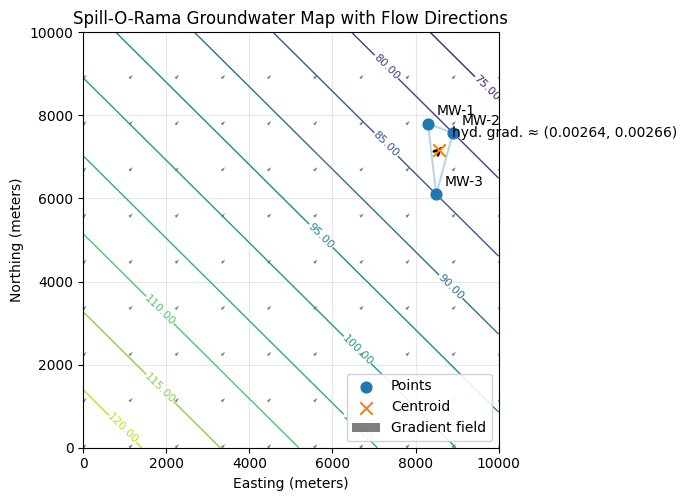

In [181]:
#!/usr/bin/env python3
"""
points_to_plane_plot.py

Given three named 3D points (name, x, y, z), solve for the plane
z(x,y) = a x + b y + c where (a, b) is the hydraulic gradient,
then produce a plot of the three (x,y) points with:
  - unit aspect ratio,
  - ~10% padded limits,
  - centroid marker,
  - a single arrow from centroid in the (a, b) direction,
  - optional contours of z(x,y),
  - optional quiver (uniform gradient field).

Usage examples
--------------
# Three points via flags (repeat --point three times)
python points_to_plane_plot.py \
  --point P1 0 0 100 \
  --point P2 10 0 98 \
  --point P3 0 10 97.5 \
  --contours 10 --quiver 10 --save plane_plot.png

# Same but just show interactively
python points_to_plane_plot.py --point A 0 0 0 --point B 1 0 -1 --point C 0 1 -1

# From CSV (name,x,y,z with header or headerless):
#   P1,0,0,100
#   P2,10,0,98
#   P3,0,10,97.5
python points_to_plane_plot.py --csv points.csv --contours 8 --quiver 12

Notes
-----
- If points imply a vertical/near-vertical plane (not representable as z=ax+by+c),
  the solve will fail with a clear message.
"""

from __future__ import annotations
import argparse
from typing import List, Tuple, Optional
import csv
import numpy as np
import matplotlib.pyplot as plt

Point = Tuple[str, float, float, float]

# ---------- Math core ----------
def solve_plane_axy_plus_by_plus_c(points: List[Point], rtol: float = 1e-12) -> Tuple[float, float, float]:
    """
    Solve z(x,y) = a x + b y + c from exactly three points (name, x, y, z).
    Returns (a, b, c). Here (a, b) is the hydraulic gradient.
    """
    if len(points) != 3:
        raise ValueError("Provide exactly three points.")
    xs = np.array([p[1] for p in points], dtype=float)
    ys = np.array([p[2] for p in points], dtype=float)
    zs = np.array([p[3] for p in points], dtype=float)

    # Build system: [x y 1] [a b c]^T = z
    M = np.column_stack([xs, ys, np.ones(3, dtype=float)])
    rank = np.linalg.matrix_rank(M, tol=rtol)
    if rank < 3:
        raise ValueError(
            "Cannot represent the plane as z = a x + b y + c.\n"
            "The points likely imply a vertical/near-vertical plane or duplicate (x,y)."
        )
    a, b, c = np.linalg.solve(M, zs)
    return float(a), float(b), float(c)

# ---------- Plotting ----------
def plot_xy_with_overlays(points: List[Point],
                          a: float, b: float, c: float,
                          arrow_frac: float = 0.10,
                          pad_frac: float = 0.10,
                          contour_levels: Optional[int | List[float]] = None,
                          quiver_grid: Optional[int] = None,
                          title: str = "Points with Plane Contours and Gradient Overlays"):
    """
    Make the requested plot with unit aspect, padding, centroid/arrow, optional contours & quiver.

    Parameters
    ----------
    arrow_frac : fraction of max(xspan, yspan) used for the centroid arrow length (default 0.10)
    pad_frac   : fractional padding added to min/max limits (default 0.10)
    contour_levels : None (no contours), int (#levels), or explicit list of levels
    quiver_grid : None (no quiver) or number of vectors per axis
    """
    names = [p[0] for p in points]
    xs = np.array([p[1] for p in points], dtype=float)
    ys = np.array([p[2] for p in points], dtype=float)
    zs = np.array([p[3] for p in points], dtype=float)

    # Centroid and spans
    X0, Y0 = xs.mean(), ys.mean()
    xspan = xs.max() - xs.min()
    yspan = ys.max() - ys.min()
    span  = max(xspan, yspan, 1e-12)
    pad   = pad_frac * span
    # Generic sizing
    xmin, xmax = xs.min() - pad, xs.max() + pad
    ymin, ymax = ys.min() - pad, ys.max() + pad
    # Override sizing
    xmin, xmax = 0, 10000
    ymin, ymax = 0, 10000    

    # Arrow length scale in (a,b) direction (-a,-b are gradient)
    norm_ab = float(np.hypot(a, b))
    D = (arrow_frac * span) / norm_ab if norm_ab > 1e-15 else 0.0
    X1, Y1 = X0 - a * D, Y0 - b * D

    fig, ax = plt.subplots(figsize=(6.8, 6.8))

    # Points & triangle
    ax.scatter(xs, ys, s=60, zorder=3, label="Points")
    for name, x, y in zip(names, xs, ys):
        ax.annotate(name, (x, y), textcoords="offset points", xytext=(6, 6))
    ax.plot([xs[0], xs[1], xs[2], xs[0]], [ys[0], ys[1], ys[2], ys[0]], alpha=0.3)

    # Centroid and arrow
    ax.scatter([X0], [Y0], marker='x', s=80, zorder=4, label="Centroid")
    ax.annotate("", xy=(X1, Y1), xytext=(X0, Y0),
                arrowprops=dict(arrowstyle="->", linewidth=2))
    ax.annotate(f"hyd. grad. ≈ ({-a:.3g}, {-b:.3g})", (X1, Y1),
                textcoords="offset points", xytext=(6, 6))

    # Contours of z = a x + b y + c
    if contour_levels is not None:
        gx = np.linspace(xmin, xmax, 201)
        gy = np.linspace(ymin, ymax, 201)
        XX, YY = np.meshgrid(gx, gy, indexing="xy")
        ZZ = a * XX + b * YY + c
        cs = ax.contour(XX, YY, ZZ, levels=contour_levels, linewidths=1.0)
        ax.clabel(cs, inline=True, fmt="%.2f", fontsize=8)

    # Quiver: constant field (a,b); normalize for clean visual
    if quiver_grid is not None and norm_ab > 1e-15:
        qx = np.linspace(xmin, xmax, quiver_grid)
        qy = np.linspace(ymin, ymax, quiver_grid)
        QX, QY = np.meshgrid(qx, qy, indexing="xy")
        u = -a / norm_ab
        v = -b / norm_ab
        scale = 0.07 * span  # vector length ~7% of span
        ax.quiver(QX, QY, u, v, angles='xy', scale_units='xy', scale=1/scale,
                  width=0.003, alpha=0.5, label="Gradient field")

    ax.set_xlabel("Easting (meters)")
    ax.set_ylabel("Northing (meters)")
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
# manual override limits
#    ax.set_xlim(0, 10000)  # Manual Override 
#    ax.set_ylim(0, 10000)  # Manual Override 
    ax.grid(True, alpha=0.3)
#    ax.legend(loc="best", framealpha=0.9)
    ax.legend(loc="lower right", framealpha=0.9)
    plt.tight_layout()
    return fig, ax

# ---------- I/O helpers ----------
def read_points_from_csv(path: str) -> List[Point]:
    points: List[Point] = []
    with open(path, newline="") as f:
        rdr = csv.reader(f)
        for row in rdr:
            if not row or row[0].strip().startswith("#"):
                continue
            # Try to detect header: name,x,y,z
            if len(row) >= 4 and row[1].strip().lower() == "x" and row[2].strip().lower() == "y":
                continue
            name = row[0].strip()
            x = float(row[1]); y = float(row[2]); z = float(row[3])
            points.append((name, x, y, z))
    if len(points) != 3:
        raise ValueError(f"CSV must contain exactly 3 points; got {len(points)}.")
    return points

def parse_args() -> argparse.Namespace:
    p = argparse.ArgumentParser(description="Solve z=a x + b y + c from 3 points and plot overlays.")
    src = p.add_mutually_exclusive_group(required=True)
    src.add_argument("--csv", type=str, help="CSV file with rows: name,x,y,z (header ok).")
    src.add_argument("--point", nargs=4, action="append", metavar=("NAME","X","Y","Z"),
                     help="Specify a point (repeat exactly three times).")
    p.add_argument("--contours", type=str, default=None,
                   help="Contour levels: integer (e.g., 10) or comma list (e.g., 95,96,97).")
    p.add_argument("--quiver", type=int, default=None,
                   help="Quiver grid size (e.g., 10). Omit for no quiver.")
    p.add_argument("--arrow-frac", type=float, default=0.10,
                   help="Centroid arrow length as fraction of plot span (default 0.10).")
    p.add_argument("--pad-frac", type=float, default=0.10,
                   help="Axis padding as fraction of span (default 0.10).")
    p.add_argument("--save", type=str, default=None, help="Path to save the figure (e.g., out.png).")
    p.add_argument("--title", type=str, default="Points with Plane Contours and Gradient Overlays")
    return p.parse_args()

def coerce_points_from_args(ns: argparse.Namespace) -> List[Point]:
    if ns.csv:
        return read_points_from_csv(ns.csv)
    assert ns.point is not None
    if len(ns.point) != 3:
        raise ValueError(f"Provide exactly three --point entries; got {len(ns.point)}.")
    pts: List[Point] = []
    for name, sx, sy, sz in ns.point:
        pts.append((str(name), float(sx), float(sy), float(sz)))
    return pts

def parse_contour_levels(s: Optional[str]) -> Optional[int | List[float]]:
    if s is None:
        return None
    s = s.strip()
    # integer?
    try:
        return int(s)
    except ValueError:
        pass
    # list
    levels: List[float] = [float(tok) for tok in s.split(",") if tok.strip() != ""]
    if not levels:
        return None
    return levels

# ---------- Main ----------
def main():
    ns = parse_args()
    points = coerce_points_from_args(ns)
    a, b, c = solve_plane_axy_plus_by_plus_c(points)

    print(f"a = {a:.6f}, b = {b:.6f}, c = {c:.6f}")
    print(f"Hydraulic gradient x component == {-a:.6f}")
    print(f"Hydraulic gradient y component == {-b:.6f}")
    print(f"Plane: z(x,y) = {a:.6f} x + {b:.6f} y + {c:.6f}")

    levels = parse_contour_levels(ns.contours)
    fig, ax = plot_xy_with_overlays(points, a, b, c,
                                    arrow_frac=ns.arrow_frac,
                                    pad_frac=ns.pad_frac,
                                    contour_levels=levels,
                                    quiver_grid=ns.quiver,
                                    title=ns.title)
    if ns.save:
        fig.savefig(ns.save, dpi=200, bbox_inches="tight")
        print(f"Saved figure to: {ns.save}")
    else:
        plt.show()

if __name__ == "__main__":
### SUPPLY MW DATA AS A LIST OF TUPLES ###
    pts = [
        ("MW-1", 8300.0, 7800.0, 81.0),
        ("MW-2", 8900.0, 7580.0, 80.0),
        ("MW-3", 8500.0, 6100.0, 85.0),
    ]
### EQUATION OF THE PLANE ###
    a, b, c = solve_plane_axy_plus_by_plus_c(pts)
    print(f"a={a:.6f}, b={b:.6f}, c={c:.6f}")
    print(f"Hydraulic gradient x component == {-a:.6f}")
    print(f"Hydraulic gradient y component == {-b:.6f}")

### GENERATE PRETTY PLOT ###
    # manual adjust in plotting function to extend plot area
    myTitle = "Spill-O-Rama Groundwater Map with Flow Directions"
    plot_xy_with_overlays(pts, a, b, c, arrow_frac=0.10, pad_frac=0.10,contour_levels = 10,quiver_grid = 10, title = myTitle)

Next we would add the drawdown effect of the pumping well to the regional flow to display the distortion in the vicinity of PW-1 to the plot.